# Radial Profiling

Stars are far enough away that they should be infintesimally small point sources in simplified theory. However, light gets scattered and dispersed on it's journey to us from the star, and by the time it reaches us stars appear as circles, though still very small ones.
Radial profiling, in this context, refers to when we look at how the brightness changes as a function of radius, and characterize how the light from a point source has been spread out. There is one specific thing we want to verify in this stage, but we can also use some data we gain along the way to be less general in the next stage; photometry.

Scattering is a physical process, and is absolutely included and covered in the course material, although it is scheduled to be later in the semester. As a result of that, we will lean on the safe side, and assume you haven't covered it in depth yet.

As always though, we first need to bring in our path information, so copy over the cell from the master notebook

In [ ]:
import sys
#My QAOP folder is in: /Users/aidanmcclung/Desktop/Summer_Exoplanets

codeFilePath = '/Users/aidanmcclung/Desktop/Summer_Exoplanets/'  #/QAOP/ <- we want the folder containing QAOP folder.
sys.path.append(codeFilePath) #this lets python know to look here for import statements

In [ ]:
#we also will want to know where our data and images are
from QAOP.QAOP_utils import readConfigFile
extraCodeFilePath, dataFilePath, errormsg = readConfigFile( configPath= codeFilePath + 'QAOP/')
print(errormsg) 
#print(dataFilePath)#you can check this looks right

## Introduction to scattering (and why we'd do radial profiling)

Scattering is a collection of processes where photons are deflected slightly on their journey to us from the star. These might be things like gravitatonal lensing, or light being absorbed and then reemitted but dust, or a wide variety of other things.
For the sake of being able to proceed and do calculations, we will assume that the number of times a photon gets deflected, and how much it gets deflected by, are both Completely Random. If we were to then look at a distribution of where photons from a single point source would end up, we should see the shape of a Gaussian.

If there were problems, like the star being oversaturated or not a star, we would see it look different.
Specifically for oversaturation, it would have a plateau at the top like in the following image

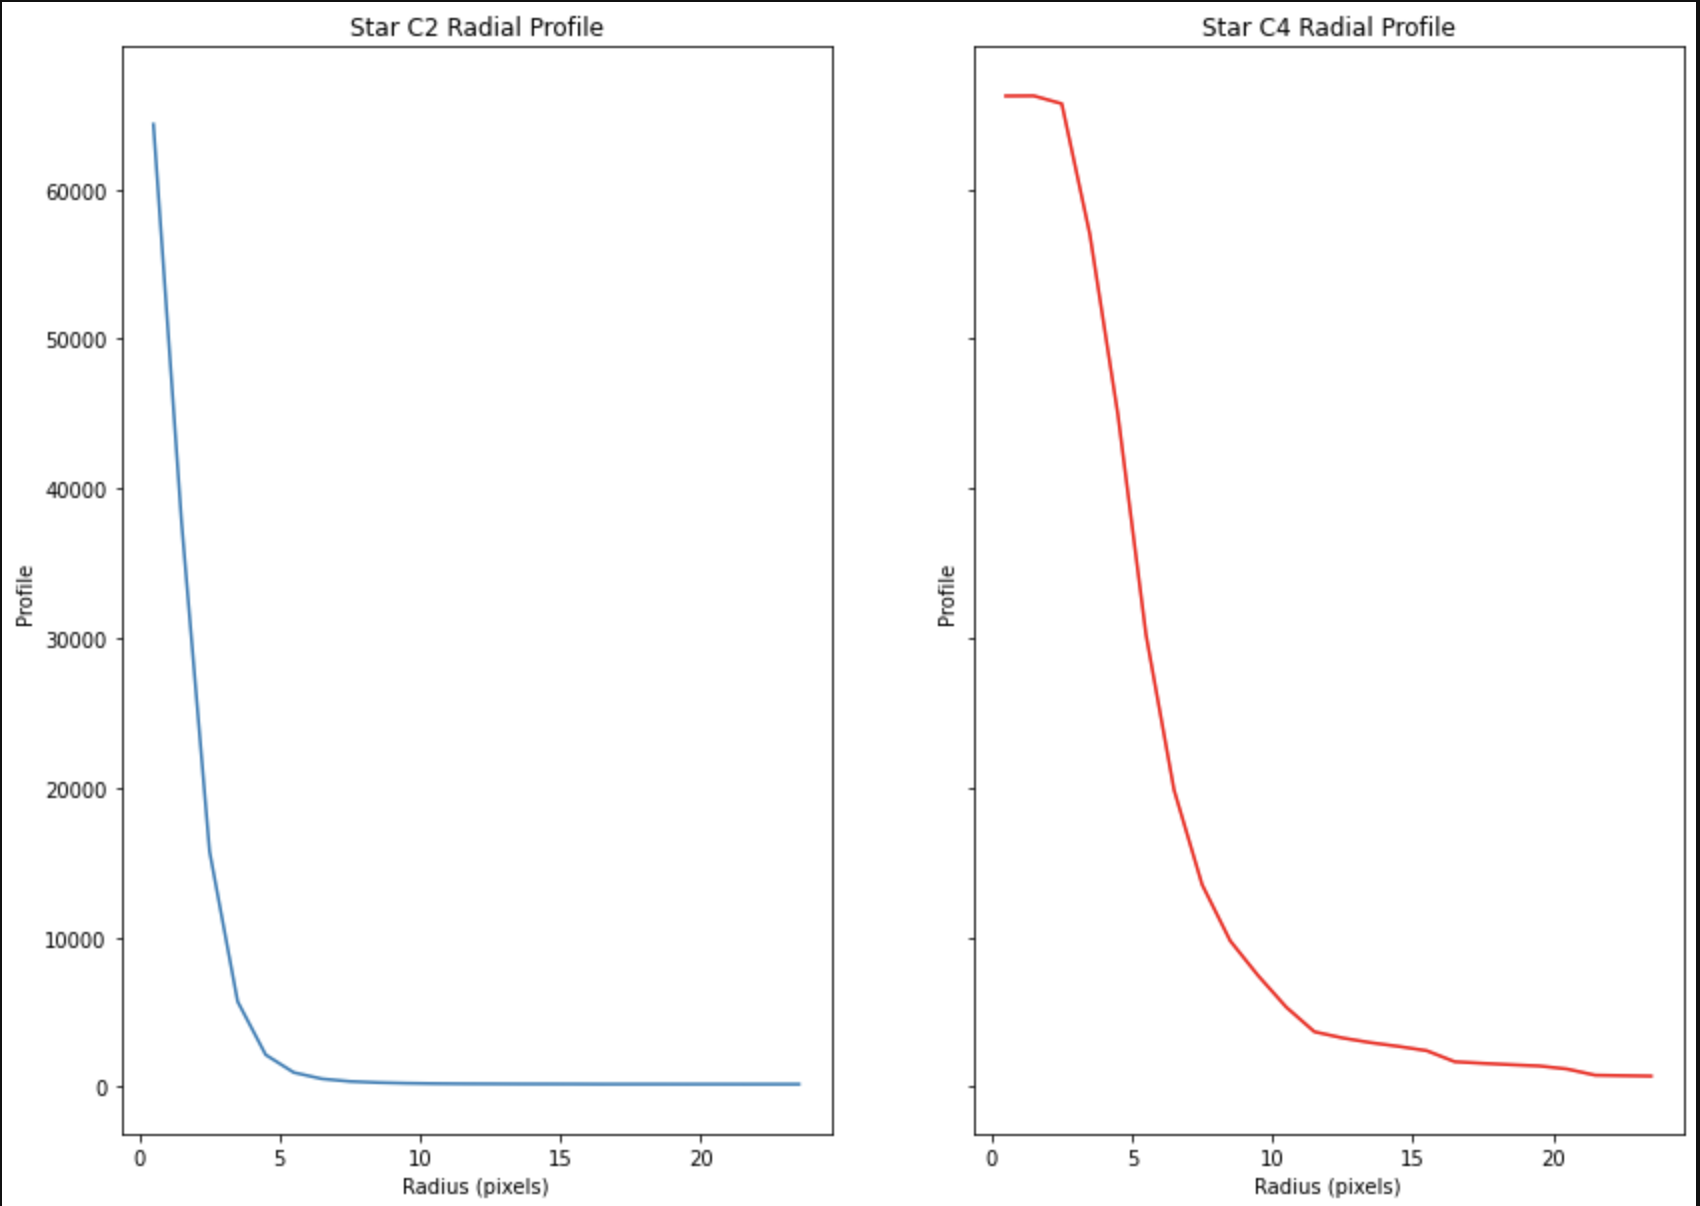

So we firstly check to make sure that our Radial Profiles follow a gaussian. But, once we do that, there's a very helpful thing we can look at: 
Since we had to figure out the parameters of a gaussian that would fit our data, we can use the standard deviation as a proportionality constant to define our photometric values (namely, the radius of the area we'll add up the light from).
We'll just use some factor times that value, and then we can be absolutely certain we'll get the significant majority of the light from a star in our area. (while also being sure that we don't have too much area that doesn't have a significant amount of light that's being included)

-------
will need to rework these descriptions into a logical order:


Firstly we're checking to make sure that our target star is not oversaturated; CCDs have a pretty limited response. In our bucket analogy, this is like how much water can fit into a bucket. if we dump in more water than could fit, then it will spill out.
To premptively answer why that would be bad since, following the analogy, if we wanted to figure out how much water was dumped, we could still get the total volume, since the water has just moved into the surrounding buckets, so it's helpful to clarify why that won't be something we can do. 
As might be expected, the problem lies in the analogy. The CCD is not actually counting photons; it is counting electrons. When a photon enters the 'bucket' the idea is that we have a material there which will have a (or a consistent number of) electron(s) which have that photons energy transferred to them, and they then go zooming off, and we can then record the voltage when we're done collecting. But, if we knock off a lot of electrons, it starts to get less and less consistent. -Need to ask Laura to help (re)explain to me how we had got to that value of like 66250 or whatever, ((2^16 = 65536)) ((16 bit resolution?)) -
As in, when water splashes out of our full bucket, it might not splash into a neighbour.

So we want to make sure we're not splashing water out of our bucket. 

# Process & Psuedocode

So that's the idea behind what we're doing. The process is actually incredibly simple;
we'll open up some subset of our images. This could be as few as a single image, or you could use all of your images, it all depends on how much of a sample you feel is representative. Note though that we will need to choose only a single (average) value at the end to use, so checking every image is usually unnecessary unless you're troubleshooting other problems.

You should be doing this stage after you've "Plate Solved" your images using Astrometry.net, and after you've "named" the bright stars and saved their locations. Both of those steps will be relevant and used, so you need to make sure that they're done before you start this.

For a single image: 
we will first want to open up the image, and then get the locations of all the named stars from the file that we saved (nameloc.csv)

We will then iterate through each star (name); we will get it's location, ie the centre of it's gaussian spread, which is it's peak, and we will then look at it's surounding points, and plot/record their pixel value and radius (distance from the centre). 

    It will be up to you to look at these plots and judge whether or not it's flat at the top. 

We will then take this data we plotted, and fit a gaussian to it. We will be fitting for only the standard deviation and the amplitude, since the mean should be zero (the gaussian should be centered on the origin).

We will then record these parameters in an external location, and then continue iterating through all the named stars for that image.

We can then check and see what the average is, and what the values are, and use that to inform whether we continue doing it for more images.

    Once we're satisfied that we are not oversaturated, and we have a representative value for the standard deviation, we will use that value to define the radii that we will use for our apertures. 
At this point, we will take the existing data file containing the name and locations of our stars, and add in a handful more columns with these radii, which will be the definitions of our apertures (`apertures.csv`)

# Psuedocode

- import our packages
- open up the list of named stars and their locations
- generate an externally stored (empty) list of the radii and parameters from radial profile fitting

Adding an images data:
1. open up the image, and get the things we need; image, and the WCS info.
2. For each named star/location:
    1. Generate the radial profile for that location
    2. (if it's the star we care about (default to 'target') then show a plot of it's radial profile.
    3. Fit a gaussian to that radial profile
    4. dump the extra stuff and return the parameters
3. be able to display the results; ie, see the average and whatnot.

Finishing and creating aperture file:
1. create a new table that's a copy of the names and locations
2. use the value that we've found (either grab the median from some saved/stored data, or input it manually) to generate/calculate the radii that we care about.
3. add a new column to the table for these radii, where all the values are the same 
4. save the new table as "apertures.csv"

In [ ]:
#import statements
from astropy.table import Table #implementation of data tables in python
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits # how to open and read fits files
from astropy.wcs import WCS # extraction of world coordinates from fits header

from astropy.coordinates import SkyCoord # A bundled way to describe a location (RA,DEC)
import astropy.units as u #unit functionality; we need deg or arcsec for SkyCoord to be happy
from astropy.wcs.utils import skycoord_to_pixel # a method to convert RA/DEC to pixel, given a wcs object for an image
from photutils.centroids import centroid_quadratic # Subpixel locating thing - needed for RadialProfile
from photutils.profiles import RadialProfile # What does the gaussian fitting for us! Yay!!

-----
With all of our packages loaded in, we can get started. 

If we've done things correctly, we should have a data file containing a list of stars and the RA and DEC they are located at, which we will load in.

In [ ]:
nameLocTable = Table.read(dataFilePath+'nameloc.csv')
#print(nameLocTable)

To study our stars, we will need to open up and look at the radial profiles, so we'll go through that first. 

A lot of the hard parts have already been done for us thankfully, and are implemented in the `photutils RadialProfile` we imported.

It does have a few specific requirements we need to meet though; formats it wants parameters in and such.

The first is the location; RadialProfile will want a special `centroid` object. What this is, is a pixel coordinate, but it's broken down to "sub-pixel". It figures this out by looking at the slopes and doing some calculus to figure out where the highest point is.

One bonus complication that we made for ourselves is that `RadialProfile` and `centroid_quadratic` work in pixel coordinates, but we converted all of our locations into RA and DEC, so, to get started and get you working, fill out the following function to take in a row of the table, and return an x and y pixel value for the image. 

If you need some reminders, you can check the corresponding section in the StarID notebook, but, it is important to note that we'll need the WCS object for the image we're dealing with.

RadialProfile will also want us to define a set of radii to use and examine, but this is a simple use of using `range` to make an x-axis.

In [ ]:
with fits.open(dataFilePath+'output/001.fits') as hdul:
    sample_wcs = WCS(hdul[0].header)
    
radii = np.arange(26)

In [ ]:
#to see what format a table row has:

sample_row = nameLocTable[4]
print(sample_row)

In [ ]:
def getXYfromRow(table_row,wcs=sample_wcs):
    
    #Fill in this function
    
    return x,y


getXYfromRow(sample_row,wcs=sample_wcs)

    NOTE: You will not be able to move on and do the rest of this notebook without a working function to get the XY coordinates
    

Now that we're able to get x and y coordinates, we can run it into a `RadialProfile` object and see what comes out.

To do this we will need an image though!

In [ ]:
with fits.open(dataFilePath+'output/001.fits') as hdul:
    sample_wcs = WCS(hdul[0].header)
    sample_image = hdul[0].data
    
    pixcoord = getXYfromRow(sample_row)
    
    sample_rp = RadialProfile(sample_image,pixcoord,radii)
    print(sample_rp)

Okay, so that worked, and we have a radial profile object. 

That object contains all the things we could need or want, and it's already done the calculations it needs.

What it has done, is it has made a plot of the pixel value as a function of radius. It then will fit a Gaussian to that distribution, and stores those parameters it found. Lets take a look at the plot, and then the parameters:

In [ ]:
sample_rp.plot()

In [ ]:
print(sample_rp.gaussian_fit)
#print(sample_rp.gaussian_profile) #the points to plot to overlay the fit
print('FWHM:',sample_rp.gaussian_fwhm,'pixels') #fwhm is proportional to stddev, and it's just been precalculated

## Checking Saturation

One of the most important things to make sure at this stage, is that none of the stars we've selected are oversaturated. 

If they are, the radial profile will have a section right close at the start (in the first few pixels) where it is flat or deviates from a gaussian.

Fill out the following cell, and check that none of your stars are oversaturated. If any are, thats not a problem; just make a note of it somewhere you'll remember so we don't use them later.

In [ ]:
for star in nameLocTable: #"for ___ in table" will give us the rows of the table.
    #Fill out this loop to check all your stars. It's probably smart to print their names as well if you do have any bad ones.
    continue
    print("make a plot showing the star is not oversaturated")
    pass

## Choosing aperture Radii for our analysis

The next step in our analysis will consist of drawing circles around each of the stars we've found, and then counting up how much light (pixel values) are inside those circles. 

To do that though, we want to make sure that we draw our circles in such a way that they do encompass all of the light from the star.

We can figure that out by using a value proportional to the FWHM, or, just as applicably, a value proportional to the Standard Deviation of the Gaussian fit to the radial profile. Recall that the definition of the standard deviation is that is the radius (from the mean) which contains 68% of the area. (We have a mean of 0; our curve is centered at the middle of the star)

Since the definition is that it is the radius which contains some amount of the light, by just going out a few more we can be certain that we have all of the light. (3 times the standard deviation covers ~99.7% of the area, which certainly could be 'all' of the light)


What we should probably do is open up an image, and look at what that FWHM or stddev is for each of the stars in our list.

Depending on how that goes, we might decide that a median value will be good for all the stars, or that we need to be a bit more specific, but in both cases, we should then take that value we decide on, and choose radii based on it.

(Spoiler: all of our starlight travelled through the same atmosphere from a very small region of sky, so they are all similarly affected, regardless of how bright they are.)

So, lets do that!

In [ ]:
print(nameLocTable[-1])
print(nameLocTable[-2])

In [ ]:
sample_fwhms, sample_stddevs = [],[]

#we already have an image as sample_image from before
for star in nameLocTable[:-1]:
    pixcoord = getXYfromRow(star)
    thisrp = RadialProfile(sample_image,pixcoord,radii)
    #print(thisrp)
    sample_fwhms.append(thisrp.gaussian_fwhm)
    sample_stddevs.append(thisrp.gaussian_fit.stddev.value)

print(sample_fwhms)
print(sample_stddevs)

Now that we have those arrays, we can do things like take the median of them, or plot them.

The answer is really that we take the median, and it should work well for all of our stars.

One thing you should do though, is try doing the cell above with a few different images throughout your timespan, and seeing if things change.

If you're really feeling thorough, you could save the medians from each image to an list, and then take the mean/median of that list to be your final value

In [ ]:
#Satisfy yourself with your choice for a FWHM. The simplest thing is to take np.median(sample_fwhms)

## Creating the Aperture Definitions

In order to make these apertures, you should have satisfied yourself that you have a representative value for the FWHM for all of your images. 


In [ ]:

reigning_median = "(paste your value here (as a number))"

print("The current reigning Median is:",reigning_median,'pixels')

In [ ]:
#figure out the pixel to degree relation; since same telescope, should be same for all images.

with fits.open(dataFilePath+'output/001.fits') as hdul:
    #print(repr(hdul[0].header))
    pix_to_deg_x = hdul[0].header['CD1_1']
    pix_to_deg_y = hdul[0].header['CD2_2']
    #print(pix_to_deg_x,pix_to_deg_y)
    pix_to_deg = np.mean([pix_to_deg_x,pix_to_deg_y])


In [ ]:
#we need to use that pixel to degree relation. 
FWHM_to_use = reigning_median*pix_to_deg

#and then we'll need to define the aperture sizes:
radius = 2*FWHM_to_use
radius_inner = 5*FWHM_to_use
radius_outer = 9*FWHM_to_use

Now we need to write those radii to a file, just like we did with `nameloc`. In fact, we will actually do this by copying `nameloc`, adding new columns, and then writing that to a new file.

In [ ]:
#and now we make and save the tables
import astropy.units as u
aperTab = nameLocTable.copy()
#print(aperTab)

r=radius*u.deg
r_in=radius_inner*u.deg
r_out=radius_outer*u.deg

aperTab['r'] = np.full(len(aperTab),r)
aperTab['r_in'] = np.full(len(aperTab),r_in)
aperTab['r_out'] = np.full(len(aperTab),r_out)

#print(aperTab)
aperTab.write(dataFilePath+'apertures.csv',format='csv',overwrite=True)

## Checking our stars and sources

Now that we know about our apertures sizes, and where the circles are, it's worth taking a moment to examine and check each of the stars we're using.

The outer donut is what we're using to estimate the background, and in order for that to be accurate, there needs to not be any stars in that ring.

As well, keep an eye out for any stars that look like they're not in the ring.

Once again, stars that break these rules don't need to be dealt with right now (they can stay in the list), but you should make a note of them and avoid using them later.

### Checking our stars and sources

Before we get on to doing the photometry, we should do the checks that we can and get rid of any stars that would be bad comparison stars. 

These are things we can look for and check:
- Oversaturation
- Nearby stars
    - either shifting background estimate
    - or bleeding into that stars count
- Things that aren't stars
    
    
The first and third items we kind of checked already; it could have been possible to identify them with our radial profile plots. Oversaturated stars would have a flat top end to their distribution, and things that aren't actually stars wouldn't look like a distribution, rather more like spikes.

For the second option, we will need to plot images for each of our stars, and overlay the circles we're going to draw when counting.

    You will need to replace all of the `sample_` objects with the ones you're actually going to use

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cbook as cbook

from astropy.table import Table

In [ ]:
#First we will need to read in our apertures; we can either load in a table, or read line by line like this:
#with open(dataFilePath+'apertures.csv') as apFile:
    #print(apFile.readline())
    
aperTab = Table.read(dataFilePath+'apertures.csv')

In [ ]:
#you may need to reimport some of these; 
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.coordinates import SkyCoord

with fits.open(dataFilePath+'output/001.fits') as hdul:
    sample_img = hdul[0].data
    sample_wcs = WCS(hdul[0].header)
    sample_pix_to_deg = np.mean([hdul[0].header['CD2_2'],hdul[0].header['CD1_1']])

----
#### Individual task:

It will be up to you to do a substantial portion of the coding to plot the apertures.

    You will need to first figure out the values that you will need to plot the apertures circles. 
    Your function should take in a row of a table, and create !! THREE !! circles, one for the inner aperture and two for the edges of the annulus. The function then needs to return the name of the star.

In [ ]:
def plotApertures(table_row):
    
    #First your function should figure out the values you'll need for plotting by reading the table row.
    
    #Fill in your function to make the circles on the plot
    #Hint: you should use plt.Circle, and give it x,y,a radius, an edgecolor, and remove the fill
    #like: sample_circle = plt.Circle((x, y), radius={},lw={}, edgecolor='',fill={False})
    
    #Make sure to actually plot your circles with plt.gca().add_patch(sample_circle)
    
    #Don't forget to zoom in as well!
    
    star_name = table_row['Name']
    return star_name

    You will need to have filled out the plotApertures function in order for the next cell to work.
    
    Once you have, running the following cell should create an image for each of your stars. Look at each image, and look for ones that have stars in their annulus, or close by, and also ones that don't have a star in the middle at all.
   
    Make a note of each of these stars so you can remove them after you've looked through.

In [ ]:
import matplotlib as mpl #for color Normalization
image = sample_img #REPLACE WITH YOUR IMAGE

def createApertureFigure(image):
    plt.figure(figsize=(16,10)) #make the plot bigger
    plt.imshow(image, cmap='Greys_r', origin='lower', norm=mpl.colors.LogNorm(vmin=1))
    plt.colorbar(label='Pixel Intensity')
    #star_name = plotApertures()
    
for row in aperTab:
    createApertureFigure(image) 
    
    star_name = plotApertures(row)
    
    plt.title("Apertures for "+star_name)
    plt.show()

## Removing Stars (or locations without a star)

Until now I've said that you should just write down the ones that are bad and then ignore them later. This can still be done, and you can do that all the way until the end, but there is a point where it's best to just get rid of some of them.

If you have assembled a list of stars which are bad, you can remove them now. 
We need AT LEAST one star other than our target for the differential step, so if you remove all the stars you should get some new ones to replace them.

Other than the need for one, it's entirely up to you to remove and edit your stars until you're satisfied. Its also up to you how you remove those stars; I've made a little demo showing how to remove a row from a table, but you can choose which table you remove it from. This table will probably be the nameLoc or aperture table, and in both cases you should rewrite the file with the shortened table.

(as a mention of the benefits of some of them: you could remove them from the apertures table and move on to photometry right away, or you could remove them from the nameLoc and rerun the radial profile analysis to get a *better* value for the FWHM you should use. If you're feeling up to a challenge, you could also go back to when we were naming and identifying stars, remove the ones that we've since identified as bad, and then replace them with different ones. You'll probably need to create a list of coordinates to blacklist, since the names depended on the order they were, which could change as you add more stars.)

In [ ]:
sample_rows = [['Zanada','five','0'],['Albert','a','1'],['Bagot','b','2'],['Collingwood','c','3'],['Division','d','4'],['Eniversity','eggs','2.718']]
sample_table = Table(rows=sample_rows, names=['Name','A','N'])
print(sample_table)

In [ ]:
sample_names_to_remove = ["Eniversity",'Zanada']


sample_indexs_to_remove = []

for i,name in enumerate(sample_table['Name'].data):
    if sample_names_to_remove.count(name): sample_indexs_to_remove.append(i)

#We have to remove the indexes after we find them all: otherwise they'd change...
sample_table.remove_rows(sample_indexs_to_remove)
    
print(sample_table)

In [ ]:
#Create a list of the rows/stars you want to get rid of:

#Read in the table you're going to remove them from

#Remove them

#Rewrite the table, replacing the old one!

Once you're satisfied with your modifications and star choices, return to the master notebook.